In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from datasets import load_dataset
from torch.utils.data import Dataset,DataLoader
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler

In [3]:
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
from transformers import BartForConditionalGeneration,BartTokenizer
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
tokenizer=BartTokenizer.from_pretrained("facebook/bart-base")

In [6]:
from datasets import load_dataset
ds = load_dataset("abisee/cnn_dailymail", "1.0.0")

max_src_len = 1024
max_tgt_len = 128
num_examples = 50000  # limit

# Prepare all examples using tokenizer's built-in padding/truncation
encoder_inputs = []
encoder_attn_mask = []
decoder_inputs = []
decoder_attn_mask = []
decoder_target = []

for i, example in enumerate(ds["train"]):
    if i >= num_examples:
        break

    # Encode source (article)
    enc = tokenizer(example["article"], max_length=max_src_len, padding='max_length', truncation=True)
    # Encode target (highlights)
    tgt = tokenizer(example["highlights"], max_length=max_tgt_len, padding='max_length', truncation=True)

    # encoder inputs
    encoder_inputs.append(enc['input_ids'])
    encoder_attn_mask.append(enc['attention_mask'])

    # decoder inputs: add bos token at start
    dec_input_ids = [tokenizer.bos_token_id] + tgt['input_ids'][:-1]  # shift right
    decoder_inputs.append(dec_input_ids)
    decoder_attn_mask.append([1 if t != tokenizer.pad_token_id else 0 for t in dec_input_ids])

    # labels: replace pad tokens with -100
    labels = tgt['input_ids']
    labels = [t if t != tokenizer.pad_token_id else -100 for t in labels]
    decoder_target.append(labels)


# PyTorch Dataset
class SummarizationChunk(Dataset):
    def __init__(self, enc_inputs, enc_attn_mask, dec_inputs, dec_attn_mask, target):
        self.enc_inputs = torch.tensor(enc_inputs, dtype=torch.long)
        self.enc_attn_mask = torch.tensor(enc_attn_mask, dtype=torch.long)
        self.dec_inputs = torch.tensor(dec_inputs, dtype=torch.long)
        self.dec_attn_mask = torch.tensor(dec_attn_mask, dtype=torch.long)
        self.target = torch.tensor(target, dtype=torch.long)

    def __len__(self):
        return len(self.enc_inputs)

    def __getitem__(self, idx):
        return {
            "enc_inputs": self.enc_inputs[idx],
            "enc_attn_mask": self.enc_attn_mask[idx],
            "dec_inputs": self.dec_inputs[idx],
            "dec_attn_mask": self.dec_attn_mask[idx],
            "target": self.target[idx]
        }


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [7]:
from torch.utils.data import random_split, DataLoader
train_dataset = SummarizationChunk(
    encoder_inputs, encoder_attn_mask, decoder_inputs, decoder_attn_mask, decoder_target
)
dataset_len = len(train_dataset)
# Split sizes: 90% train, 10% val
train_size = int(0.9 * dataset_len)
val_size   = dataset_len - train_size
# Optional: for reproducibility
generator = torch.Generator().manual_seed(42)
# Perform random split
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=generator)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
optimizer = AdamW(model.parameters(), lr=5e-5)
grad_clip=1.0

In [9]:

scaler = GradScaler()
def model_train(model,device,train_loader,val_loader,num_epochs,optimizer,grad_clip=None):
    model=model.to(device)
    train_losses=[]
    val_losses=[]
    train_epoch_losses=[]
    val_epoch_losses=[]


    for epoch in range(num_epochs):
        print(f"epoch: {epoch+1}/{num_epochs}")
        model.train()
        running_val_loss=0
        running_train_loss=0
        for train_step, batch in enumerate(train_loader):

            optimizer.zero_grad()
            input_ids=batch["enc_inputs"].to(device)
            attention_mask=batch["enc_attn_mask"].to(device)
            decoder_input_ids=batch["dec_inputs"].to(device)
            decoder_attention_mask=batch["dec_attn_mask"].to(device)
            labels=batch['target'].to(device)

                       # forward pass with autocast for FP16
            with autocast():
                output = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    decoder_input_ids=decoder_input_ids,
                    decoder_attention_mask=decoder_attention_mask,
                    labels=labels
                )
                loss = output.loss

            # scale the loss and backward
            scaler.scale(loss).backward()

            # gradient clipping (optional)
            if grad_clip is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            # optimizer step
            scaler.step(optimizer)
            scaler.update()
            running_train_loss += loss.item()
            if(train_step%200==0):
                train_losses.append(loss.item())

                print(f"train_loss as step {train_step} : {loss.item()}")



        train_avg_loss=running_train_loss/len(train_loader)
        train_epoch_losses.append(train_avg_loss)
        print(f"train_loss for epoch {epoch+1}:{train_avg_loss}")
        model.eval()

        with torch.no_grad():
            for val_step,batch in enumerate(val_loader):


                input_ids=batch["enc_inputs"].to(device)
                attention_mask=batch["enc_attn_mask"].to(device)
                decoder_input_ids=batch["dec_inputs"].to(device)
                decoder_attention_mask=batch["dec_attn_mask"].to(device)
                labels=batch['target'].to(device)
                # forward pass with autocast for FP16

                with autocast():
                    output = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    decoder_input_ids=decoder_input_ids,
                    decoder_attention_mask=decoder_attention_mask,
                    labels=labels
                   )
                    loss = output.loss




                running_val_loss +=loss.item()


                if(val_step%40==0):
                    val_losses.append(loss.item())
                    print(f"val_loss as step {val_step} : {loss.item()}")
            val_avg_loss= running_val_loss/len(val_loader)
            val_epoch_losses.append(val_avg_loss)

            print(f"val loss for epoch {epoch+1} : {val_avg_loss}")


        save_dir = "/content/drive/MyDrive/bart_latest"
        model.save_pretrained(save_dir)
        tokenizer.save_pretrained(save_dir)
        print(f"Model and tokenizer saved at {save_dir}")

    return {
        "train_step_losses": train_losses,
        "train_epoch_losses": train_epoch_losses,
        "val_step_losses": val_losses,
        "val_epoch_losses": val_epoch_losses
    }


/tmp/ipython-input-3441385589.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [12]:
import matplotlib.pyplot as plt



def plot_losses(result):
    # --- Step-wise loss plot ---
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(result["train_step_losses"], label="Train Step Loss", alpha=0.7)
    plt.plot(result["val_step_losses"], label="Val Step Loss", alpha=0.7)
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Step-wise Loss")
    plt.legend()
    plt.grid(True)

    # --- Epoch-wise loss plot ---
    plt.subplot(1,2,2)
    plt.plot(result["train_epoch_losses"], marker="o", label="Train Epoch Loss", alpha=0.7)
    plt.plot(result["val_epoch_losses"], marker="o", label="Val Epoch Loss", alpha=0.7)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Epoch-wise Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()





In [10]:
bart_history= model_train(model=model,device=device,train_loader=train_loader,val_loader=val_loader,num_epochs=3,optimizer=optimizer,grad_clip=None)


epoch: 1/3


/tmp/ipython-input-3441385589.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


train_loss as step 0 : 5.29125452041626
train_loss as step 200 : 2.702394485473633
train_loss as step 400 : 2.288930892944336
train_loss as step 600 : 2.23677134513855
train_loss as step 800 : 2.5359909534454346
train_loss as step 1000 : 2.1746013164520264
train_loss as step 1200 : 1.8243767023086548
train_loss as step 1400 : 2.6074607372283936
train_loss as step 1600 : 2.392016887664795
train_loss as step 1800 : 2.428328275680542
train_loss as step 2000 : 1.811736822128296
train_loss as step 2200 : 2.383352518081665
train_loss as step 2400 : 2.4432709217071533
train_loss as step 2600 : 2.185012102127075
train_loss as step 2800 : 2.5194239616394043
train_loss as step 3000 : 2.408531427383423
train_loss as step 3200 : 2.3400862216949463
train_loss as step 3400 : 1.8149100542068481
train_loss as step 3600 : 2.4514567852020264
train_loss as step 3800 : 2.331010103225708
train_loss as step 4000 : 2.374040365219116
train_loss as step 4200 : 2.6785597801208496
train_loss as step 4400 : 2.251

/tmp/ipython-input-3441385589.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


val_loss as step 0 : 1.9499225616455078
val_loss as step 40 : 2.132322311401367
val_loss as step 80 : 2.1102466583251953
val_loss as step 120 : 1.8798998594284058
val_loss as step 160 : 2.106102705001831
val_loss as step 200 : 2.249779224395752
val_loss as step 240 : 1.6606899499893188
val_loss as step 280 : 1.6449382305145264
val_loss as step 320 : 1.5696799755096436
val_loss as step 360 : 2.0073530673980713
val_loss as step 400 : 1.7052172422409058
val_loss as step 440 : 2.382661819458008
val_loss as step 480 : 2.2709808349609375
val_loss as step 520 : 1.9169424772262573
val_loss as step 560 : 2.3004796504974365
val_loss as step 600 : 1.7102782726287842
val loss for epoch 1 : 1.9250131099700927


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:4034: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Model and tokenizer saved at /content/drive/MyDrive/bart_latest
epoch: 2/3
train_loss as step 0 : 2.3404834270477295
train_loss as step 200 : 1.8199422359466553
train_loss as step 400 : 2.0539753437042236
train_loss as step 600 : 2.065744638442993
train_loss as step 800 : 1.8382400274276733
train_loss as step 1000 : 1.9071691036224365
train_loss as step 1200 : 2.007042646408081
train_loss as step 1400 : 1.6429953575134277
train_loss as step 1600 : 1.8387348651885986
train_loss as step 1800 : 1.8724397420883179
train_loss as step 2000 : 1.8992681503295898
train_loss as step 2200 : 1.8599728345870972
train_loss as step 2400 : 1.7444630861282349
train_loss as step 2600 : 1.9564794301986694
train_loss as step 2800 : 1.9818521738052368
train_loss as step 3000 : 1.9334865808486938
train_loss as step 3200 : 1.9533379077911377
train_loss as step 3400 : 1.7117327451705933
train_loss as step 3600 : 1.9229134321212769
train_loss as step 3800 : 2.071970224380493
train_loss as step 4000 : 2.1927242

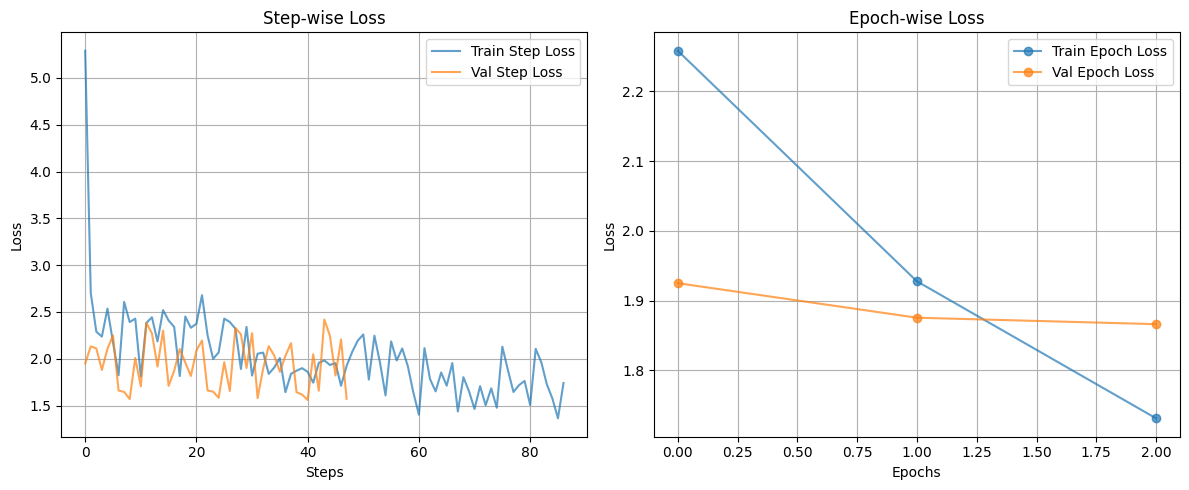

In [13]:
plot_losses(bart_history)